In [3]:
from data import load, split, ScaleAbsOne
from gpytorch.constraints import Positive
import torch
import math
import gpytorch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [4]:
df = load()
train_set, dev_set, test_set = split(df, "new_dose-response_matrices", inner_fold=1, outer_fold=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


In [6]:
sub = torch.tensor(train_set[:150]).float()
subt = torch.tensor(train_target[:150].values).float()

In [7]:
# sub = torch.randn(150, 400)
# subt = torch.randn()

In [8]:
def train(model, likelihood, training_iter, x, y):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    pbar = tqdm(range(training_iter)) 
    for i in pbar:
        optimizer.zero_grad()
        output = model(x)
        loss = -mll(output, y)
        pbar.set_description(f'{loss.item():.2e}')
        loss.backward()
        optimizer.step()

In [34]:
class MultiLinearKernel(gpytorch.kernels.Kernel):
    is_stationary = False
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)
        
        self.register_parameter(
            name='raw_length', 
            parameter=torch.nn.Parameter(torch.ones(*self.batch_shape, 1, 1, 400) * 100)
        )
        if length_constraint is None:
            length_constraint = Positive()
        self.register_constraint("raw_length", length_constraint)

        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # This is expensive, but I'm not sure how to improve it
        # For the Gram at least it's a symmetric tensor
        # We could do it iteratively and at least save some RAM
        prod = torch.einsum("nd, md -> nmd", x1, x2)
        frac = (self.length**2 + prod) / (1 + self.length**2)
        return frac.prod(-1)
    
class LogMLK(MultiLinearKernel):
    def forward(self, x1, x2, **params):
        # This is expensive, but I'm not sure how to improve it
        # For the Gram at least it's a symmetric tensor
        # We could do it iteratively and at least save some RAM
        prod = torch.einsum("nd, md -> nmd", x1, x2)
        frac = (self.length**2 + prod).log() -torch.log(1 + self.length**2)
        return frac.sum(-1)
    
    
class MultiLinearGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, lazy=False):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if not lazy:
            self.covar_module = MultiLinearKernel()
        else:
            self.covar_module = LazyMultilinearKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
from gpytorch.lazy import lazify
from torch.nn import ModuleList
class LazyMultilinearKernel(gpytorch.kernels.Kernel):
    #Shamelessly copied/adapted from Gpytorch Productkernel and Gabriel
    @property
    def is_stationary(self) -> bool:
        """
        Kernel is stationary if all components are stationary.
        """
        return False

    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.kernels = ModuleList([gpytorch.kernels.PolynomialKernel(power=1) for _ in range(400)])
        self._set_offset(1.)
        

    def forward(self, x1, x2, diag=False, **params):
        div_terms = (self.get_offsets() + 1)
        def get_term(d):
            k = self.kernels[d]
            return k(x1[...,d].unsqueeze(1), x2[...,d].unsqueeze(1), diag=diag, **params)/div_terms[d]

                
        x1_eq_x2 = torch.equal(x1, x2)

        if not x1_eq_x2:
            # If x1 != x2, then we can't make a MulLazyTensor 
            # because the kernel won't necessarily be square/symmetric
            res = delazify(get_term(0))
        else:
            res = get_term(0)

            if not diag:
                res = lazify(res)

        for d in range(1, 400):
            next_term = get_term(d)
            if not x1_eq_x2:
                # Again delazify if x1 != x2
                res = res * delazify(next_term)
            else:
                if not diag:
                    res = res * lazify(next_term)
                else:
                    res = res * next_term
        return res


    def _set_offset(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.kernels[0].raw_offset)
        for k in self.kernels:
            k._set_offset(value)
            
    def get_offsets(self):
        return torch.cat([k.offset for k in self.kernels])


In [31]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MultiLinearGPModel(sub, subt, likelihood, lazy=True)

model.train()
likelihood.train()
train(model, likelihood, 100, sub, subt)

model.eval()
likelihood.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [32]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MultiLinearGPModel(sub, subt, likelihood, lazy=False)

model.train()
likelihood.train()
train(model, likelihood, 100, sub, subt)

model.eval()
likelihood.eval()

  0%|          | 0/100 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

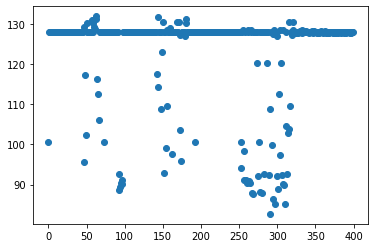

In [63]:
plt.scatter(range(sub.shape[-1]), model.covar_module.length.detach().cpu().numpy())

In [37]:
kernel = LogMLK()

In [42]:
for _ in range(500):
    x = torch.randn(100)
    K = kernel(x, x)
    x2 = torch.randn(100)
    print(x2[None, :] @ K.evaluate() @ x2[:, None])


tensor([[0.0756]], grad_fn=<MmBackward>)
tensor([[0.6433]], grad_fn=<MmBackward>)
tensor([[-1.3332]], grad_fn=<MmBackward>)
tensor([[1.6217]], grad_fn=<MmBackward>)
tensor([[1.1415]], grad_fn=<MmBackward>)
tensor([[-0.5643]], grad_fn=<MmBackward>)
tensor([[-1.6458]], grad_fn=<MmBackward>)
tensor([[-6.4092]], grad_fn=<MmBackward>)
tensor([[10.5152]], grad_fn=<MmBackward>)
tensor([[-4.8986]], grad_fn=<MmBackward>)
tensor([[-1.4236]], grad_fn=<MmBackward>)
tensor([[6.2425]], grad_fn=<MmBackward>)
tensor([[-1.7134]], grad_fn=<MmBackward>)
tensor([[-0.7303]], grad_fn=<MmBackward>)
tensor([[16.4810]], grad_fn=<MmBackward>)
tensor([[0.9441]], grad_fn=<MmBackward>)
tensor([[0.1209]], grad_fn=<MmBackward>)
tensor([[2.3244]], grad_fn=<MmBackward>)
tensor([[-0.6377]], grad_fn=<MmBackward>)
tensor([[0.0843]], grad_fn=<MmBackward>)
tensor([[-0.2511]], grad_fn=<MmBackward>)
tensor([[-7.5081]], grad_fn=<MmBackward>)
tensor([[0.7227]], grad_fn=<MmBackward>)
tensor([[0.4750]], grad_fn=<MmBackward>)
ten

tensor([[-0.1682]], grad_fn=<MmBackward>)
tensor([[-0.8289]], grad_fn=<MmBackward>)
tensor([[14.2039]], grad_fn=<MmBackward>)
tensor([[-1.4843]], grad_fn=<MmBackward>)
tensor([[6.9760]], grad_fn=<MmBackward>)
tensor([[0.0560]], grad_fn=<MmBackward>)
tensor([[-4.6640]], grad_fn=<MmBackward>)
tensor([[-2.9969]], grad_fn=<MmBackward>)
tensor([[-1.3984]], grad_fn=<MmBackward>)
tensor([[-2.9710]], grad_fn=<MmBackward>)
tensor([[0.0869]], grad_fn=<MmBackward>)
tensor([[-1.2777]], grad_fn=<MmBackward>)
tensor([[7.7262]], grad_fn=<MmBackward>)
tensor([[7.7461]], grad_fn=<MmBackward>)
tensor([[1.0556]], grad_fn=<MmBackward>)
tensor([[0.1763]], grad_fn=<MmBackward>)
tensor([[-1.2189]], grad_fn=<MmBackward>)
tensor([[2.8369]], grad_fn=<MmBackward>)
tensor([[4.9628]], grad_fn=<MmBackward>)
tensor([[-5.2168]], grad_fn=<MmBackward>)
tensor([[8.5615]], grad_fn=<MmBackward>)
tensor([[1.0723]], grad_fn=<MmBackward>)
tensor([[-2.2352]], grad_fn=<MmBackward>)
tensor([[5.3622]], grad_fn=<MmBackward>)
tens

tensor([[-2.3964]], grad_fn=<MmBackward>)
tensor([[0.2247]], grad_fn=<MmBackward>)
tensor([[0.0138]], grad_fn=<MmBackward>)
tensor([[5.0344]], grad_fn=<MmBackward>)
tensor([[8.4647]], grad_fn=<MmBackward>)
tensor([[0.0575]], grad_fn=<MmBackward>)
tensor([[0.5135]], grad_fn=<MmBackward>)
tensor([[13.2787]], grad_fn=<MmBackward>)
tensor([[7.9870]], grad_fn=<MmBackward>)
tensor([[27.3812]], grad_fn=<MmBackward>)
tensor([[7.3710]], grad_fn=<MmBackward>)
tensor([[12.1896]], grad_fn=<MmBackward>)
tensor([[-0.4429]], grad_fn=<MmBackward>)
tensor([[-1.0411]], grad_fn=<MmBackward>)
tensor([[2.6782]], grad_fn=<MmBackward>)
tensor([[-0.3610]], grad_fn=<MmBackward>)
tensor([[-1.6694]], grad_fn=<MmBackward>)
tensor([[3.5372]], grad_fn=<MmBackward>)
tensor([[1.4067]], grad_fn=<MmBackward>)
tensor([[-5.9603]], grad_fn=<MmBackward>)
tensor([[-9.1578]], grad_fn=<MmBackward>)
tensor([[-1.1885]], grad_fn=<MmBackward>)
tensor([[2.5209]], grad_fn=<MmBackward>)
tensor([[16.0492]], grad_fn=<MmBackward>)
tens